In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from ms.handler.metadata_source import TabzillaSource
from ms.metaresearch.meta_learner import MetaLearner
from ms.metaresearch.meta_model import MetaModel
from ms.metaresearch.selector_data import SelectorData
from sklearn.linear_model import LogisticRegression

D:\python_projects\MetaSelect\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.metrics import make_scorer, balanced_accuracy_score, f1_score, roc_auc_score

md_source = TabzillaSource()
grid_scoring = "b_acc"
model_scoring = {
    'b_acc': make_scorer(balanced_accuracy_score),
    'f1': make_scorer(f1_score, average='weighted'),
    'roc': make_scorer(
        roc_auc_score, 
        average='weighted',
        max_fpr=None,
        multi_class="ovo",
        response_method="predict_proba"
    ),
}

In [3]:
meta_learner = MetaLearner(
    md_source=md_source,
    opt_scoring=grid_scoring,
    model_scoring=model_scoring,
    features_folder="preprocessed",
    metrics_folder="preprocessed",
    use_optuna=True,
    opt_cv=5,
    model_cv=10,
    n_trials=50,
    test_mode=False,
)

In [4]:
lr = MetaModel(
    name="logreg",
    display_name="Logistic Regression",
    model=LogisticRegression(),
    params={
        "penalty": ["l2"],
        "C": [0.01, 0.1, 1, 10],
        "solver": ["newton-cholesky", "lbfgs", "sag", "saga"],
    }
)

mlp = MetaModel(
    name="mlp",
    display_name="MLP",
    model=MLPClassifier(),
    params={
        "hidden_layer_sizes": [(10,), (25,), (50,)],
        "activation": ["logistic", "relu", "tanh"],
        "solver": ["lbfgs", "sgd", "adam"],
        "alpha": [0.001, 0.01, 0.1],
        "batch_size": ["auto", 10, 25, 50],
        "learning_rate": ["adaptive"],
        "learning_rate_init": [0.001, 0.01, 0.1],
        "max_iter": [25, 50, 100, 200],
    },
)

xgb = MetaModel(
    name="xgb",
    display_name="XGBoost",
    model=XGBClassifier(),
    params={ 
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [5, 10, 50, 100],
        "eval_metric" : ["merror", "mlogloss"], 
    },
)

knn = MetaModel(
    name="knn",
    display_name="KNN",
    model=KNeighborsClassifier(),
    params={
        "n_neighbors": [3, 5, 7],
        "weights": ["uniform", "distance"],
        "leaf_size": [10, 20, 30, 50],
        "algorithm": ["auto"],
        "p": [1, 2],
    }
)

In [5]:
base_selector = SelectorData("no_selector")

In [6]:
meta_learner.run_models(
    models=[lr, knn, xgb, mlp],
    feature_suffix="power",
    target_suffixes=["perf_abs", "perf_rel", "diff"],
    selectors=[base_selector],
    rewrite=False
)

Selector: no_selector
Target file: metrics__perf_abs.csv
Metamodel: logreg
Metamodel: knn
Metamodel: xgb
Metamodel: mlp
Target file: metrics__perf_rel.csv
Metamodel: logreg
Metamodel: knn
Metamodel: xgb
Metamodel: mlp
Target file: metrics__diff.csv
Metamodel: logreg
Metamodel: knn
Metamodel: xgb
Metamodel: mlp


In [7]:
mean_cols = ["test_b_acc_mean", "test_f1_mean", "test_roc_mean", "fit_score_time_mean"]
names = ["b_acc", "f1", "roc", "fit+score time, s"]
std_cols = ["test_b_acc_std", "test_f1_std", "test_roc_std", "fit_score_time_std"]
target_models = [
    "LR",
    "RF",
    "XGB",
    "FTT",
    "MLP",
    "RN"
]

In [8]:
from ms.metaresearch.plotting import Plotter

plotter = Plotter(
    md_source=md_source,
    mean_cols=mean_cols,
    std_cols=std_cols,
    names=names,
    rewrite=False,
)

In [9]:
plotter.plot(
    models=[lr, knn, xgb, mlp],
    target_suffixes=["perf_abs", "perf_rel"],
    selectors=[base_selector],
    target_models=target_models,
)

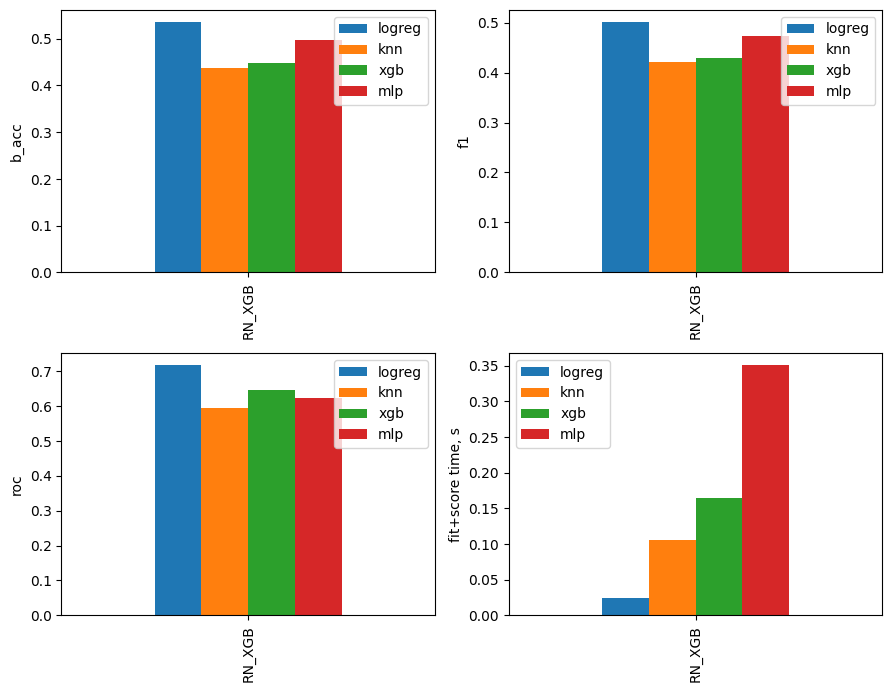

In [10]:
plotter.plot(
    models=[lr, knn, xgb, mlp],
    target_suffixes=["diff"],
    selectors=[base_selector],
    target_models=["RN_XGB"],
)